In [1]:
import os
from time import time
from tqdm import tqdm
import numpy as np

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
plt.style.use('ggplot')


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_data(batch_size=64):
    # Create Dataset
    TRAIN_ROOT = "/Users/harinder/Downloads/New Plant Diseases Dataset(Augmented)/train"
    VALID_ROOT = "/Users/harinder/Downloads/New Plant Diseases Dataset(Augmented)/valid"

    train_ds = ImageFolder(TRAIN_ROOT, transform=tfm)
    test_ds = ImageFolder(VALID_ROOT, transform=tfm)
    
    # Length of Train and Test Datasets
    LEN_TRAIN = len(train_ds)
    LEN_TEST = len(test_ds)
    print(LEN_TRAIN, LEN_TEST)

    # Index Mapping
    print(train_ds.class_to_idx)
    
    # Data Loader
    train_loader = DataLoader(train_ds, batch_size = 64, shuffle=True)
    valid_loader = DataLoader(test_ds, batch_size = 64, shuffle = True)
    
    return train_loader, valid_loader

In [2]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join('/Users/harinder/Downloads/New Plant Diseases Dataset(Augmented)', name+'_accuracy.png'))
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('/Users/harinder/Downloads/New Plant Diseases Dataset(Augmented)', name+'_loss.png'))

In [3]:
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Train DataSet')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [4]:
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Valid Dataset')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [5]:
import torch.optim as optim
import random

# Set seed.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

In [6]:
# Learning and training parameters.
epochs = 10
batch_size = 64
learning_rate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loader, valid_loader = get_data(batch_size=batch_size)
# Define model based on the argument parser string.
print('[INFO]: Training ResNet18 built from scratch...')
# Model
model = resnet18(pretrained=True)
model = model.to(device)
plot_name = 'resnet_scratch'
#print(model)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Loss function.
criterion = CrossEntropyLoss()

42347 10586
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Raspberry___healthy': 18, 'Soybean___healthy': 19, 'Squash___Powdery_mildew': 20, 'Strawberry___Leaf_scorch': 21, 'Strawberry___healthy': 22}
[INFO]: Training ResNet18 built from scratch...
11,689,512 total parameters.
11,689,512 training parameters.


/Users/harinder/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/harinder/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Epoch 1 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:12:57<00:00,  3.31s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:11<00:00,  1.73it/s]


Training loss: 0.161, training acc: 96.540
Validation loss: 0.020, validation acc: 99.358
--------------------------------------------------
[INFO]: Epoch 2 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:19:55<00:00,  3.62s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:12<00:00,  1.72it/s]


Training loss: 0.023, training acc: 99.294
Validation loss: 0.012, validation acc: 99.641
--------------------------------------------------
[INFO]: Epoch 3 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:19:26<00:00,  3.60s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:12<00:00,  1.72it/s]


Training loss: 0.016, training acc: 99.544
Validation loss: 0.011, validation acc: 99.603
--------------------------------------------------
[INFO]: Epoch 4 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:19:27<00:00,  3.60s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:12<00:00,  1.72it/s]


Training loss: 0.010, training acc: 99.719
Validation loss: 0.011, validation acc: 99.650
--------------------------------------------------
[INFO]: Epoch 5 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:19:30<00:00,  3.60s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:12<00:00,  1.72it/s]


Training loss: 0.008, training acc: 99.754
Validation loss: 0.010, validation acc: 99.613
--------------------------------------------------
[INFO]: Epoch 6 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:19:25<00:00,  3.60s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:12<00:00,  1.72it/s]


Training loss: 0.006, training acc: 99.828
Validation loss: 0.007, validation acc: 99.754
--------------------------------------------------
[INFO]: Epoch 7 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:19:22<00:00,  3.60s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:12<00:00,  1.72it/s]


Training loss: 0.005, training acc: 99.858
Validation loss: 0.006, validation acc: 99.811
--------------------------------------------------
[INFO]: Epoch 8 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:16:17<00:00,  3.46s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:25<00:00,  1.61it/s]


Training loss: 0.005, training acc: 99.882
Validation loss: 0.008, validation acc: 99.707
--------------------------------------------------
[INFO]: Epoch 9 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:01:27<00:00,  2.78s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:28<00:00,  1.59it/s]


Training loss: 0.004, training acc: 99.924
Validation loss: 0.005, validation acc: 99.802
--------------------------------------------------
[INFO]: Epoch 10 of 10
Train DataSet


100%|█████████████████████████████████████| 1324/1324 [1:02:23<00:00,  2.83s/it]


Valid Dataset


100%|█████████████████████████████████████████| 331/331 [03:31<00:00,  1.57it/s]


Training loss: 0.003, training acc: 99.950
Validation loss: 0.007, validation acc: 99.802
--------------------------------------------------
TRAINING COMPLETE


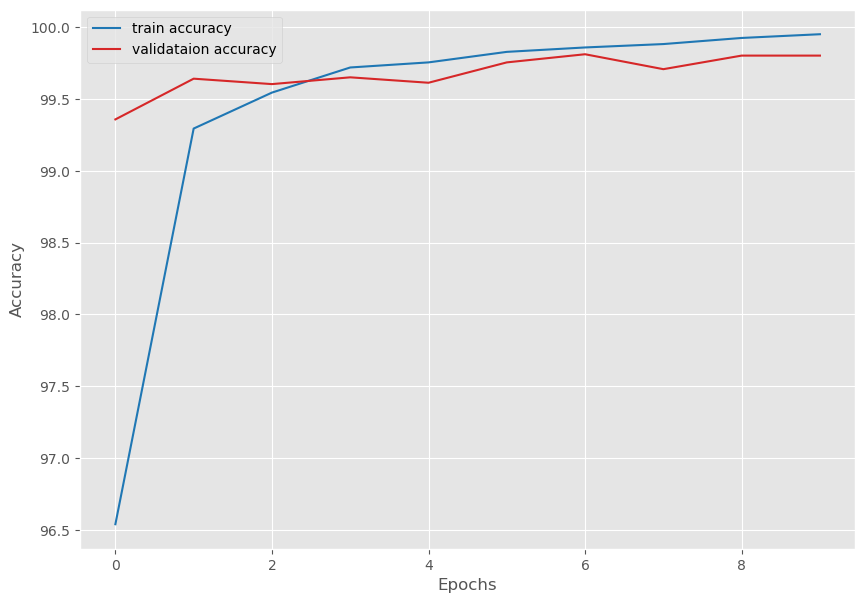

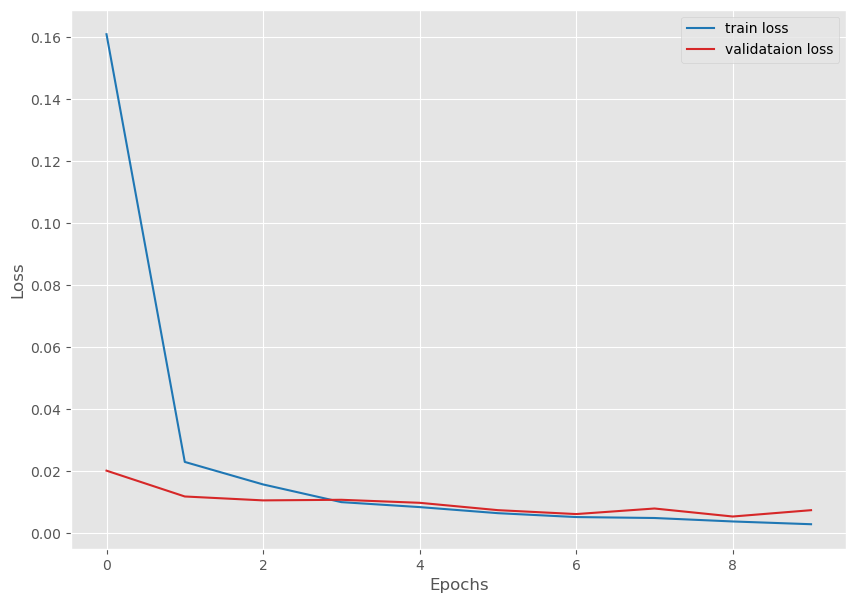

In [7]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
        
# Save the loss and accuracy plots.
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name=plot_name
)
print('TRAINING COMPLETE')